# Normalized Voxels: Align Planes, Adjust Contrast, and Crop

As shown in several notebooks, MRI plane type (Axial, Coronal, and Sagittal) is not consistent among patients or MRI scan types (FLAIR, T1w, T1wCE, T2w).
While augmentations might alleviate this inconsistency, it is better to train models using MRI voxels that are consistent in terms of plane type.
This notebook shows we can obtain normalized voxels by appropriately rotating MRI voxels.
I found that simply rotating MRI voxels is not enough because the order of planes is also inconsistent in some cases.
For example, even with the same Sagittal type, some of scans were in left-to-right order, while others were the other way around.
As Instance Number does not help, Image Position (Patient) is used in this notebook to reorder stacked images.
After normalized voxels with respect to planes, contrast is adjusted and then voxels are cropped.
Finally, the voxel is resized to arbitrary fixed size.

## Normalized Voxel Datasets

The normalized voxels created the above procedure were stored as a dataset. Please refer to the second half of this notebook.

In [ ]:
from pathlib import Path
import numpy as np
import cv2
import pydicom
import matplotlib.pyplot as plt

import pandas as pd
from tqdm import tqdm
import seaborn as sns
import pprint
import plotly.express as px

DATASET = 'train'
scan_types = ['FLAIR','T1w','T1wCE','T2w']
data_root = Path("../input/rsna-miccai-brain-tumor-radiogenomic-classification")

In [ ]:
# https://www.kaggle.com/arnabs007/part-1-rsna-miccai-btrc-understanding-the-data
# https://www.kaggle.com/davidbroberts/determining-mr-image-planes
def get_image_plane(data):
    x1, y1, _, x2, y2, _ = [round(j) for j in data.ImageOrientationPatient]
    cords = [x1, y1, x2, y2]

    if cords == [1, 0, 0, 0]:
        return 'Coronal'
    elif cords == [1, 0, 0, 1]:
        return 'Axial'
    elif cords == [0, 1, 0, 0]:
        return 'Sagittal'
    else:
        return 'Unknown'

In [ ]:
def get_voxel(study_id, scan_type):
    imgs = []
    dcm_dir = data_root.joinpath(DATASET, study_id, scan_type)
    dcm_paths = sorted(dcm_dir.glob("*.dcm"), key=lambda x: int(x.stem.split("-")[-1]))
    positions = []
    
    for dcm_path in dcm_paths:
        img = pydicom.dcmread(str(dcm_path))
        imgs.append(img.pixel_array)
        positions.append(img.ImagePositionPatient)
        
    plane = get_image_plane(img)
    voxel = np.stack(imgs)
    
    # reorder planes if needed and rotate voxel
    if plane == "Coronal":
        if positions[0][1] < positions[-1][1]:
            voxel = voxel[::-1]
            print(f"{study_id} {scan_type} {plane} reordered")
        voxel = voxel.transpose((1, 0, 2))
    elif plane == "Sagittal":
        if positions[0][0] < positions[-1][0]:
            voxel = voxel[::-1]
            print(f"{study_id} {scan_type} {plane} reordered")
        voxel = voxel.transpose((1, 2, 0))
        voxel = np.rot90(voxel, 2, axes=(1, 2))
    elif plane == "Axial":
        if positions[0][2] > positions[-1][2]:
            voxel = voxel[::-1]
            print(f"{study_id} {scan_type} {plane} reordered")
        voxel = np.rot90(voxel, 2)
    else:
        raise ValueError(f"Unknown plane {plane}")
    return voxel, plane

In [ ]:
def normalize_contrast(voxel):
    if voxel.sum() == 0:
        return voxel
    voxel = voxel - np.min(voxel)
    voxel = voxel / np.max(voxel)
    voxel = (voxel * 255).astype(np.uint8)
    return voxel

In [ ]:
def crop_voxel(voxel):
    if voxel.sum() == 0:
        return voxel
    keep = (voxel.mean(axis=(0, 1)) > 0)
    voxel = voxel[:, :, keep]
    keep = (voxel.mean(axis=(0, 2)) > 0)
    voxel = voxel[:, keep]
    keep = (voxel.mean(axis=(1, 2)) > 0)
    voxel = voxel[keep]
    return voxel

Sample planes along the longest axis and resize the sampled planes.
By sampling along the longest axis, the degradation due to sampling is minimized.
The best way is to resize twice (e.g. (x, y) axis then (y, z) axis) but it is computationally expensive.

In [ ]:
def resize_voxel(voxel, sz=64):
    output = np.zeros((sz, sz, sz), dtype=np.uint8)

    if np.argmax(voxel.shape) == 0:
        for i, s in enumerate(np.linspace(0, voxel.shape[0] - 1, sz)):
            output[i] = cv2.resize(voxel[int(s)], (sz, sz))
    elif np.argmax(voxel.shape) == 1:
        for i, s in enumerate(np.linspace(0, voxel.shape[1] - 1, sz)):
            output[:, i] = cv2.resize(voxel[:, int(s)], (sz, sz))
    elif np.argmax(voxel.shape) == 2:
        for i, s in enumerate(np.linspace(0, voxel.shape[2] - 1, sz)):
            output[:, :, i] = cv2.resize(voxel[:, :, int(s)], (sz, sz))

    return output

In [ ]:
for study_path in list(data_root.joinpath(DATASET).glob("*"))[:5]:
    study_id = study_path.name
    
    if not study_path.is_dir():
        continue

    fig = plt.figure(figsize=(12, 9))
    fig.suptitle(f"study id: {study_id}", fontsize=24)

    for i, scan_type in enumerate(scan_types):
        voxel, plane = get_voxel(study_id, scan_type)
        voxel = normalize_contrast(voxel)
        voxel = crop_voxel(voxel)
        voxel = resize_voxel(voxel)
        ax = fig.add_subplot(3, 4, i + 1)
        ax.set_title(f"{scan_type}, {plane}")
        ax.imshow(voxel[voxel.shape[0] // 2], cmap='gray')
        ax = fig.add_subplot(3, 4, i + 1 + 4)
        ax.imshow(voxel[:, voxel.shape[1] // 2], cmap='gray')
        ax = fig.add_subplot(3, 4, i + 1 + 8)
        ax.imshow(voxel[:, :, voxel.shape[2] // 2], cmap='gray')
    
    fig.show()

# (NEW) 01 Dimensions of scans
Extracting the dimensions of voxels and adding into a pandas datafrmae

In [ ]:
dims = []

for study_path in tqdm(list(data_root.joinpath(DATASET).glob("*"))):
    study_id = study_path.name
    
    #print(f"study id {study_id}")
    
    for i, scan_type in enumerate(scan_types):
        voxel, plane = get_voxel(study_id, scan_type)
        x, y, z = voxel.shape
        dim = {
            "study_id": study_id,
            "scan_type": scan_type,
            "x": x,
            "y": y,
            "z": z,
              }
        dims.append(dim)

dim_df = pd.DataFrame(dims)
dim_df.head()

In [ ]:
dim_df.to_csv('voxel_dims.csv')

In [ ]:
dim_df = pd.read_csv('voxel_dims.csv', index_col = 0)
dim_df.head(20)

In [ ]:
dim_df_unpiv = dim_df.melt(id_vars = ["study_id", "scan_type"],
                          var_name = "axis",
                          value_name = "size")
dim_df_unpiv.head(20)

In [ ]:
g = sns.displot(
    data=dim_df_unpiv, 
    x = "size",  
    col = "scan_type",
    row = "axis", 
    height = 3
)
g.set_axis_labels("Size (pixels)")
g.set_titles(row_template="'{row_name}'", col_template="'{col_name}'")
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle("Distribution of scan dimensions by channel & axes", fontsize = 24)
g.fig.savefig('01-01-kk-scan-dim-distr')

# (NEW) 02 Values Distribution
for each study_id and scan_type, calculate percentiles of values


In [ ]:
pctls = []

for study_path in tqdm(list(data_root.joinpath(DATASET).glob("*"))):
    study_id = study_path.name
    
    for i, scan_type in enumerate(scan_types):
        voxel, plane = get_voxel(study_id, scan_type)
        
        pctl = np.percentile(voxel, range(1,101), interpolation = 'higher')
        
        for i, value in enumerate(pctl, 1):
            pctl_dct = {
                "study_id": study_id,
                "scan_type": scan_type,
                "percentile": i,
                "value": value
                  }
            pctls.append(pctl_dct)

pctls_df = pd.DataFrame(pctls)
pctls_df

In [ ]:
pctls_df.to_csv('pctls.csv')

In [ ]:
pctls_df = pd.read_csv('../input/voxel-pctls/pctls.csv', index_col = 0)
pctls_df.head(20)

In [ ]:
g = sns.FacetGrid(
    data = pctls_df,
    col="scan_type", 
    col_wrap= 2,
    height = 5
)
g.map_dataframe(sns.lineplot, 
      x = "percentile",
      y = "value",
      units = "study_id",
      estimator = None,
      alpha = 0.05
     )
g.set(xlim=(60, 100))
g.add_legend()
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle("Values by Percentile for each channel type (truncated axis)", fontsize = 24)
g.fig.savefig('01-02-kk-values-distr')

In [ ]:
g = sns.FacetGrid(
    data = pctls_df,
    col="scan_type", 
    col_wrap= 2,
    height = 5
)
g.map_dataframe(sns.lineplot, 
      x = "percentile",
      y = "value",
      units = "study_id",
      estimator = None,
      alpha = 0.05
     )
g.set(xlim=(60, 100))
g.set(yscale='log')
g.set(ylim=(100, None))
g.add_legend()
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle("(Log) Values by Percentile for each channel type", fontsize = 24)
g.fig.savefig('01-03-kk-values-distr-log')

In [ ]:
pctls_df.groupby(['scan_type', 'percentile']).agg([np.mean,np.max,np.min])

# (NEW) 03 Dicom metadata

Reading a dcm file with pydicom.dcmread gives a <class 'pydicom.dataset.FileDataset'> object and printing this object shows the metadata associated with it. 

https://pydicom.github.io/pydicom/dev/reference/generated/pydicom.dataset.FileDataset.html#pydicom.dataset.FileDataset


In [ ]:
for study_path in list(data_root.joinpath(DATASET).glob("*"))[:1]:
    study_id = study_path.name

    for i, scan_type in enumerate(scan_types[:1]):
        
        dcm_dir = data_root.joinpath(DATASET, study_id, scan_type)
        dcm_paths = sorted(dcm_dir.glob("*.dcm"), key=lambda x: int(x.stem.split("-")[-1]))

        for dcm_path in dcm_paths[:1]:
            img = pydicom.dcmread(str(dcm_path))
            
            print(type(img))
            print(img)

These values can be extracted with the to_json_dict() method. Dropping the key corresponding to raw pixel data (7FE00010) as it causes the notebook to crash when printing.

In [ ]:
dct = img.to_json_dict()
print(dct.keys())
del dct['7FE00010']
print(dct.keys())
len(dct)

The number keys correspond to data elements defined within DICOM

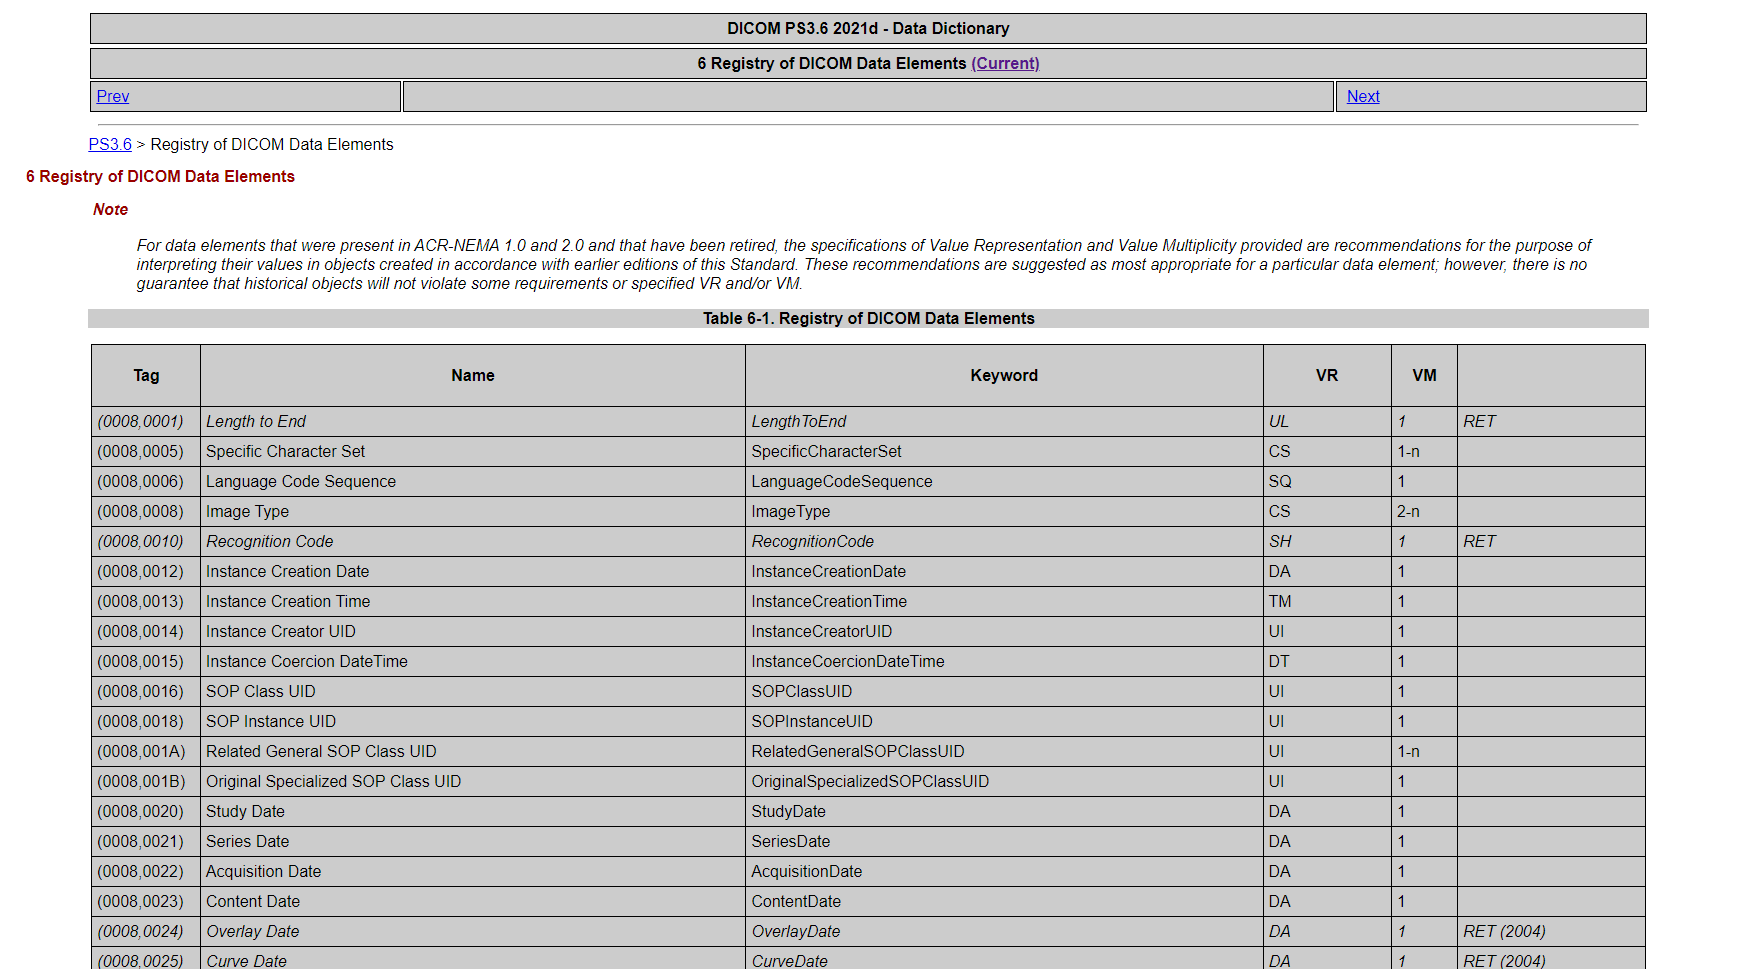
http://dicom.nema.org/medical/dicom/current/output/chtml/part06/chapter_6.html

Each data element has its data element tag (number above), and a value representation (VR) which is used to determine how the following raw data is parsed

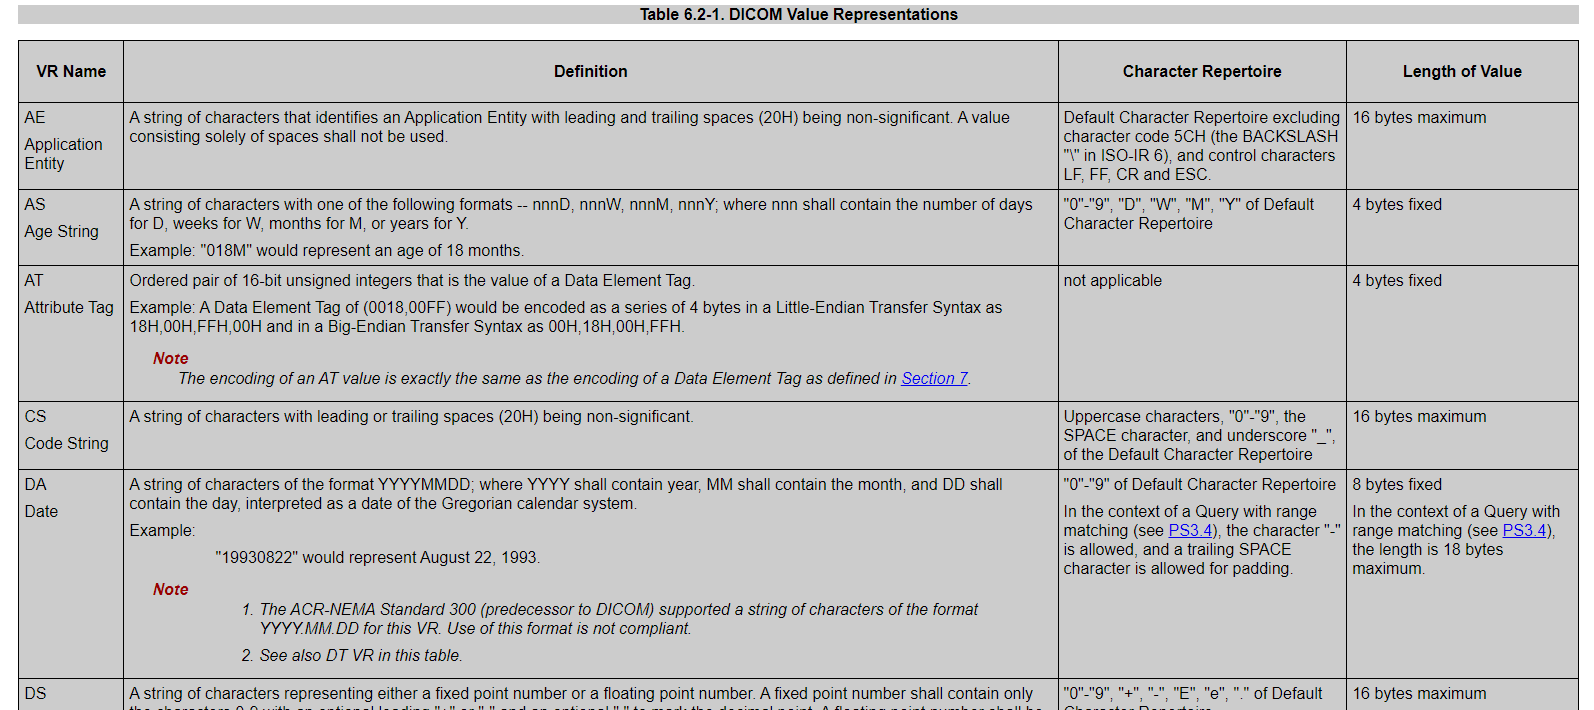

http://dicom.nema.org/medical/dicom/current/output/chtml/part05/chapter_7.html#sect_7.1.1
http://dicom.nema.org/dicom/2013/output/chtml/part05/sect_6.2.html

In [ ]:
pprint.pprint(dct)

In [ ]:
{pydicom.datadict.dictionary_description(k):v.get('Value') for k,v in dct.items()}

In [ ]:
{v.get('vr') for v in dct.values()}

* CS: Code String
* DS: Decimal String
* IS: Integer String
* LO: Long String
* PN: Person Name
* SH: Short String
* UI: Unique Identifier (UID)
* UL: Unsigned Long
* US: Unsigned Short

In [ ]:
pydicom.datadict.dictionary_description('00181314')

# (NEW) 04 Identifying which metadata is consistent within a scan

In [ ]:
meta_dcts_one_scan = []

for study_path in list(data_root.joinpath(DATASET).glob("*"))[:1]:
    study_id = study_path.name

    for i, scan_type in enumerate(scan_types[:1]):
        
        dcm_dir = data_root.joinpath(DATASET, study_id, scan_type)
        dcm_paths = sorted(dcm_dir.glob("*.dcm"), key=lambda x: int(x.stem.split("-")[-1]))

        for dcm_path in dcm_paths:
            img = pydicom.dcmread(str(dcm_path))
            meta_dct = img.to_json_dict()
            del meta_dct['7FE00010']
            meta_dcts_one_scan.append({pydicom.datadict.dictionary_description(k): v.get('Value') for k,v in meta_dct.items()})

meta_df_one_scan = pd.DataFrame(meta_dcts_one_scan)
meta_df_one_scan

In [ ]:
meta_counts_one_scan = (
    meta_df_one_scan.astype(str)
    .nunique()
    .to_frame()
    .reset_index()
)
meta_counts_one_scan.columns = ['data_element', 'distinct_count']
meta_counts_one_scan.head(15)

In [ ]:
unique_metas = meta_counts_one_scan[meta_counts_one_scan.distinct_count == 1].data_element.to_list()

print(len(unique_metas))
print(unique_metas)

In [ ]:
meta_dcts = []

for study_path in list(data_root.joinpath(DATASET).glob("*")):
    study_id = study_path.name

    for i, scan_type in enumerate(scan_types):
        
        dcm_dir = data_root.joinpath(DATASET, study_id, scan_type)
        dcm_paths = sorted(dcm_dir.glob("*.dcm"), key=lambda x: int(x.stem.split("-")[-1]))

        for dcm_path in dcm_paths[:1]:
            img = pydicom.dcmread(str(dcm_path))
            meta_dct = img.to_json_dict()
            del meta_dct['7FE00010']
            meta_dct = {
                pydicom.datadict.dictionary_description(k): v.get('Value')
                for k,v in meta_dct.items()
                if pydicom.datadict.dictionary_description(k) in unique_metas 
            }
            meta_dct["study_id"] = study_id
            meta_dct["scan_type"] = scan_type
            meta_dcts.append(meta_dct)

meta_df = pd.DataFrame(meta_dcts)
meta_df.study_id = meta_df.study_id.astype(int)
meta_df

In [ ]:
meta_df.to_csv('meta_df.csv')

In [ ]:
meta_counts= (
    meta_df.astype(str)
    .nunique()
    .to_frame()
    .reset_index()
)
meta_counts.columns = ['data_element', 'distinct_count']
meta_counts.sort_values('distinct_count')

# (NEW) 05 Combining Voxel distribution and metadata 

In [ ]:
pctls_df = pd.read_csv('../input/voxel-pctls/pctls.csv', index_col = 0)
pctls_df.astype({'percentile': int, 'value': int})
pctls_df

In [ ]:
appr_sum = (pctls_df
            .groupby(['study_id', 'scan_type'])
            .agg(np.sum)['value']
            .rename('appr_sum'))
appr_sum_sans_max = (pctls_df[pctls_df.percentile < 100]
                     .groupby(['study_id', 'scan_type'])
                     .agg(np.sum)['value']
                     .rename('appr_sum_sans_max'))
voxel_sums_df = pd.concat([appr_sum, appr_sum_sans_max], axis = 1 )
voxel_sums_df.index = voxel_sums_df.index.map(str)

def log_limit(x):
    if x == 0:
        return 0
    else: 
        return np.log(x)

voxel_sums_df['log_as'] = voxel_sums_df.appr_sum.apply(log_limit)
voxel_sums_df['log_assm'] = voxel_sums_df.appr_sum_sans_max.apply(log_limit)
voxel_sums_df.head()

In [ ]:
meta_df = meta_df.set_index(['study_id', 'scan_type'])
meta_df.index = meta_df.index.map(str)

In [ ]:
voxel_sum_meta_df = meta_df.join(voxel_sums_df)
voxel_sum_meta_df.head()

In [ ]:
candidate_meta = meta_counts[meta_counts.distinct_count.between(2,20)]

candidate_meta_list = candidate_meta.data_element.to_list()
candidate_meta_list = set(candidate_meta_list)
candidate_meta_list.remove('scan_type')
candidate_meta_list = list(candidate_meta_list)
candidate_meta_list = candidate_meta_list

candidate_meta_list

In [ ]:
subset_df = voxel_sum_meta_df[candidate_meta_list + out_cols]
subset_df.head()

In [ ]:
subset_df.columns

In [ ]:
cat_cols = ['Specific Character Set', 
            'Imaged Nucleus', 
            'Position Reference Indicator', 
            #'Series Description',
            'In-plane Phase Encoding Direction', 
            'MR Acquisition Type', ]
num_cols = ['Echo Number(s)',
            'Pixel Representation',
            'Rows','Number of Averages', 
            'Trigger Window',
            'Magnetic Field Strength',
            'Reconstruction Diameter',]
out_cols = ['appr_sum',
            'appr_sum_sans_max',
            'log_assm',
            'log_as']

In [ ]:
def first_elem(o):
    if type(o) is list:
        return o[0]
    else: return o

subset_df[num_cols] = subset_df[num_cols].applymap(first_elem)
subset_df[cat_cols] = subset_df[cat_cols].astype(str).astype('category')
subset_df.head()

In [ ]:
subset_df.dtypes

In [ ]:
numericalized = subset_df.copy(deep=True)
numericalized[cat_cols] = numericalized[cat_cols].apply(lambda x: x.cat.codes)
numericalized

In [ ]:
numericalized.dtypes

In [ ]:
fig = px.parallel_coordinates(numericalized, 
                              color = "log_assm", 
                              dimensions = num_cols+cat_cols+out_cols,
                              color_continuous_scale=px.colors.diverging.Tealrose,)
fig.show()

In [ ]:
subset_df.head()

# (NEW) 06 Analysis by scan type

In [ ]:
numericalized = numericalized[numericalized['log_assm'] != 0]

subset_flair = numericalized[numericalized['Series Description'] == "['FLAIR']"]
subset_t1w = numericalized[numericalized['Series Description'] == "['T1w']"]
subset_t1wce = numericalized[numericalized['Series Description'] == "['T1wCE']"]
subset_t2w = numericalized[numericalized['Series Description'] == "['T2w']"]



## FLAIR: expecting two clusters

In [ ]:
sns.pairplot(subset_flair, kind='hist')

In [ ]:
sns.displot(subset_flair,
            x = 'log_assm',
            row = 'MR Acquisition Type',
            hue = 'Pixel Representation')

## T1WCE: expecting 2 clusters

In [ ]:
sns.pairplot(subset_t1wce, kind='hist')

In [ ]:
sns.displot(subset_t1wce,
            x = 'log_assm',
            row = 'MR Acquisition Type',
            hue = 'Pixel Representation')

## T1W: expecting 3 clusters

In [ ]:
sns.pairplot(subset_t1w, kind='hist')

In [ ]:
sns.displot(subset_t1w,
            x = 'log_as',
            row = 'MR Acquisition Type',
            hue = 'Pixel Representation')

# (NEW) 07 Combining identified metadata with percentiles plot

In [ ]:
pctls_df = pd.read_csv('../input/voxel-pctls/pctls.csv', index_col = 0)
pctls_df.astype({'percentile': int, 'value': int})
pctls_df = pctls_df.set_index(['study_id', 'scan_type'], drop = False)
pctls_df.index = pctls_df.index.map(str)
pctls_df.head()

In [ ]:
pctls_meta_df.dtypes

In [ ]:
pctls_meta_df = pctls_df.join(subset_df[['MR Acquisition Type', 'Pixel Representation']])
pctls_meta_df['meta'] = pctls_meta_df['MR Acquisition Type'].astype(str) + ' ' + pctls_meta_df['Pixel Representation'].astype(str)
pctls_meta_df.head()

In [ ]:
g = sns.FacetGrid(
    data = pctls_meta_df,
    col="scan_type", 
    col_wrap= 2,
    height = 5
)
g.map_dataframe(sns.lineplot, 
      x = "percentile",
      y = "value",
      units = "study_id",
      hue = "meta",
      estimator = None,
      alpha = 0.05
     )
g.set(xlim=(60, 100))
g.set(yscale='log')
g.set(ylim=(100, None))
g.add_legend()
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle("(Log) Values by Percentile for each channel type", fontsize = 24)
g.fig.savefig('01-03-kk-values-distr-log')

# Normalized Voxel Datasets
The normalized voxels created the above procedure were stored as a dataset:

- [64x64x64 voxel](https://www.kaggle.com/ren4yu/rsna-miccai-voxel-64-dataset)
- [128x128x128 voxel](https://www.kaggle.com/ren4yu/rsna-miccai-voxel-128-dataset)
- [256x256x256 voxel](https://www.kaggle.com/ren4yu/rsna-miccai-voxel-256-dataset)

The directory structure is as follows:

```
voxel
├── train
│   ├── 00000
│   │   ├── FLAIR.npy
│   │   ├── T1w.npy
│   │   ├── T1wCE.npy
│   │   └── T2w.npy
│   ├── 00002
│   │   ├── FLAIR.npy
...
├── test
│   ├── 00001
│   │   ├── FLAIR.npy
│   │   ├── T1w.npy
│   │   ├── T1wCE.npy
│   │   └── T2w.npy
│   ├── 00013
│   │   ├── FLAIR.npy
```

Some voxels do not exist because all images belonging to these scans are completely black:

- ('train', '00109', 'FLAIR.npy')
- ('train', '00123', 'T1w.npy')
- ('train', '00123', 'T2w.npy')
- ('train', '00709', 'FLAIR.npy')

Let's get one voxel and visualize it.

In [ ]:
! ls ../input

In [ ]:
def load_voxel(study_id, scan_type="FLAIR", split="train", sz=256):
    assert sz in (64, 128, 256)
    data_root = Path(f"../input/rsna-miccai-voxel-{sz}-dataset")
    npy_path = Path(data_root).joinpath("voxel", split, study_id, f"{scan_type}.npy")
    voxel = np.load(str(npy_path))
    return voxel

In [ ]:
voxel = load_voxel("00000", "FLAIR", "train", 256)
voxel.shape

In [ ]:
fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 3, 1)
ax.imshow(voxel[voxel.shape[0] // 2], cmap='gray')
ax = fig.add_subplot(1, 3, 2)
ax.imshow(voxel[:, voxel.shape[1] // 2], cmap='gray')
ax = fig.add_subplot(1, 3, 3)
ax.imshow(voxel[:, :, voxel.shape[2] // 2], cmap='gray')
fig.show()